In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

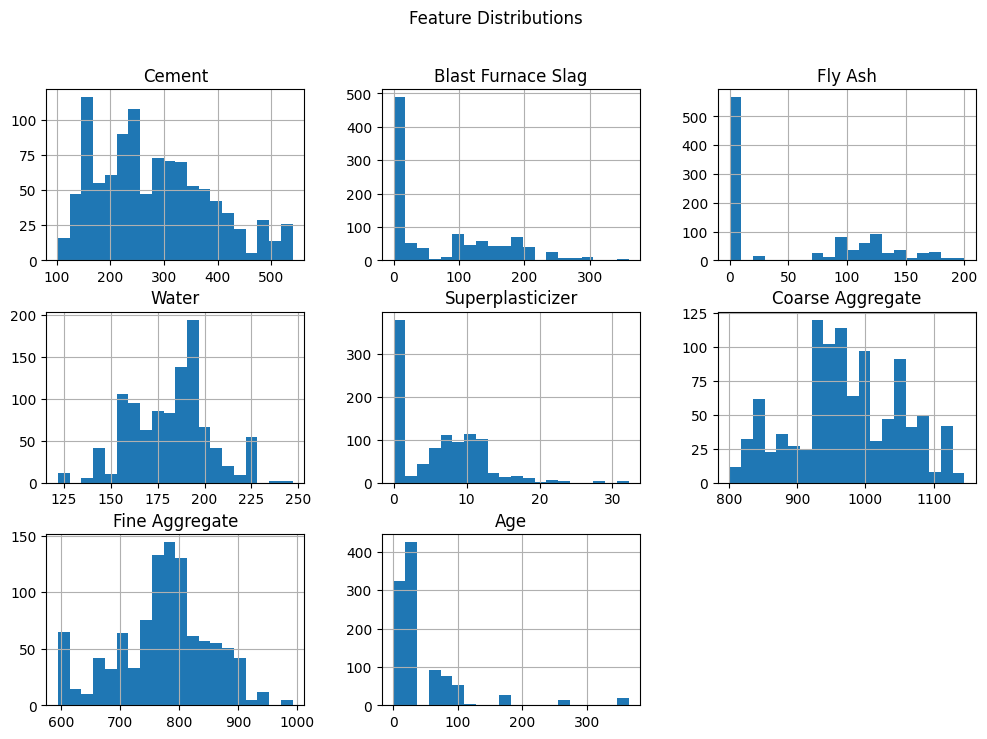

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

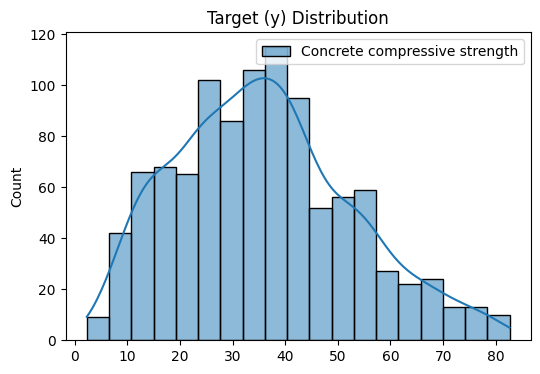

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

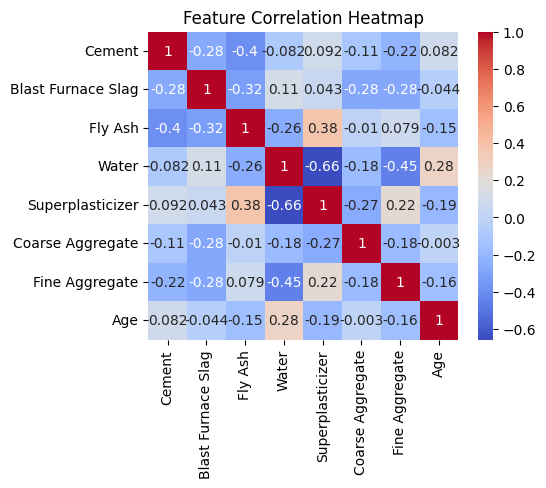

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.043970                 1.311005             1.227313   
1                  1.061841                 1.289173             1.132527   
2                  1.187548                 1.372176             1.236470   
3                  1.054202                 1.478060             1.339776   
4                  1.101375                 1.289592             1.159019   
mean               1.089787                 1.348001             1.219021   
std                0.058817                 0.080220             0.080679   

      DefaultBART_Rhat_RMSE  
0                  1.409609  
1                  1.136920  
2                  1.360691  
3                  1.690856  
4                  1.404681  
mean               1.400551  
std                0.197146  


In [8]:
rhat_df.to_csv("results/real4_Concrete_rhat.csv", index=False)

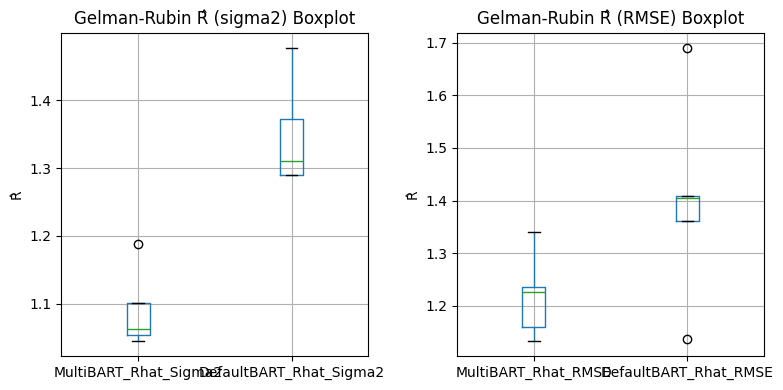

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


test_mse:
      bart_mtmh       bart        btz        sto         rf        xgb
0     17.395834  19.372470  21.362145  22.529591  25.337002  22.455559
1     18.666058  22.658328  27.050854  22.198930  28.011630  22.121190
2     17.063630  19.741612  23.918587  26.653419  22.319608  20.070588
3     19.525615  21.714616  19.248110  19.268158  24.326422  20.167277
4     13.722758  16.764769  17.904802  17.530620  24.962981  20.543163
5     18.950471  20.607829  18.519383  22.749677  26.308469  19.923279
6     16.119383  21.669444  19.867299  19.220302  25.070558  20.328900
7     12.105102  18.130100  17.063320  18.459957  21.417550  14.329891
8     26.167858  22.004921  20.727949  19.257527  31.274851  32.522720
9     21.648231  19.948987  18.529009  18.832391  25.410759  25.434845
mean  18.136494  20.261308  20.419146  20.670057  25.443983  21.789741
std    3.962811   1.853718   3.048703   2.790873   2.767778   4.683846



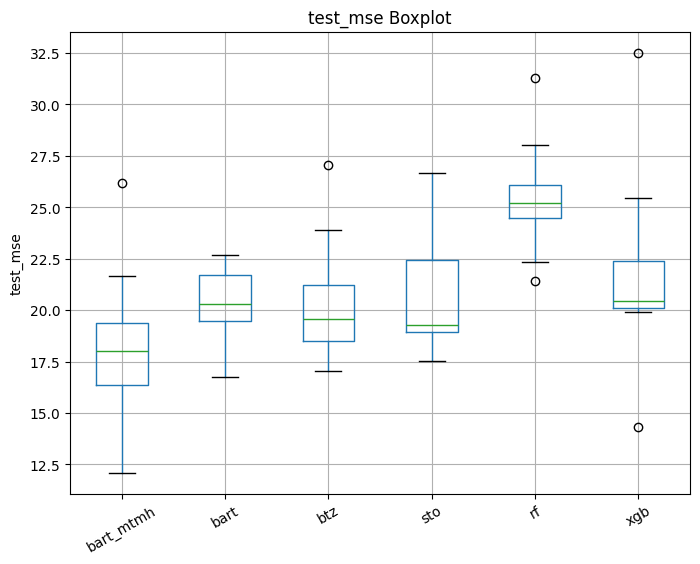

train_mse:
      bart_mtmh      bart       btz        sto        rf       xgb
0      5.000225  7.815078  8.901965   9.497296  4.507947  1.485153
1      4.856169  8.406519  7.525078  10.049322  4.546035  1.495007
2      5.248610  8.030434  7.956736  10.116911  4.560098  1.395256
3      4.831710  7.912316  8.305401   9.763532  4.021529  1.089786
4      5.074630  9.110390  8.548061  10.035958  4.354594  1.349169
5      4.379692  7.290501  8.465735  10.133070  4.597305  1.337065
6      4.477249  8.473609  8.032753  10.198832  4.637098  1.315198
7      4.894813  8.306094  9.538532  11.861006  4.734191  1.460623
8      4.623560  8.965181  7.011750  11.925350  3.413750  0.405178
9      3.885607  7.737181  7.768730  11.376606  3.984985  0.462414
mean   4.727226  8.204730  8.205474  10.495788  4.335753  1.179485
std    0.397915  0.562131  0.717062   0.881323  0.410202  0.409934



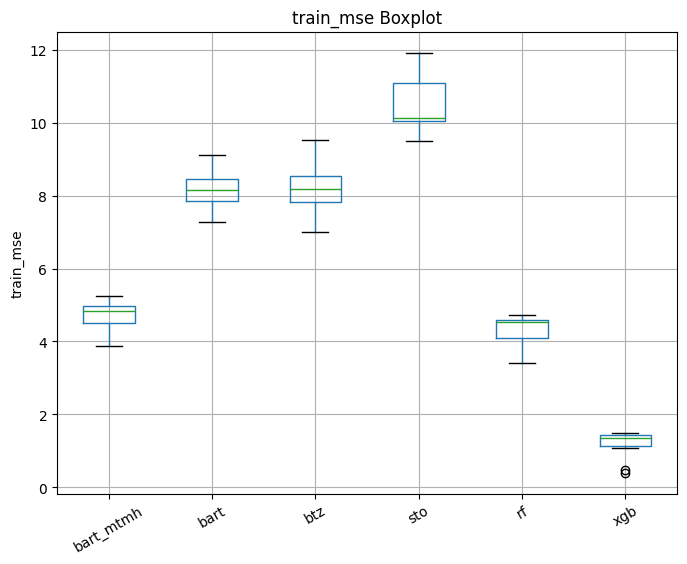

pi_length:
      bart_mtmh       bart        btz        sto
0     13.919171  14.156869  16.795211  52.292287
1     14.301349  14.548070  16.060134  47.076805
2     14.119049  13.856345  16.607350  58.435435
3     13.303682  13.922583  16.520943  54.823021
4     14.188763  14.708639  16.590460  56.105533
5     13.740979  14.239159  16.376399  48.958335
6     14.075307  13.742506  16.661673  62.852253
7     13.951388  14.653066  17.231581  59.029510
8     11.423401  14.026225  16.566344  64.761473
9     11.993477  13.664060  16.144629  50.268534
mean  13.501657  14.151752  16.555472  55.460319
std    0.993796   0.378159   0.329532   5.898354



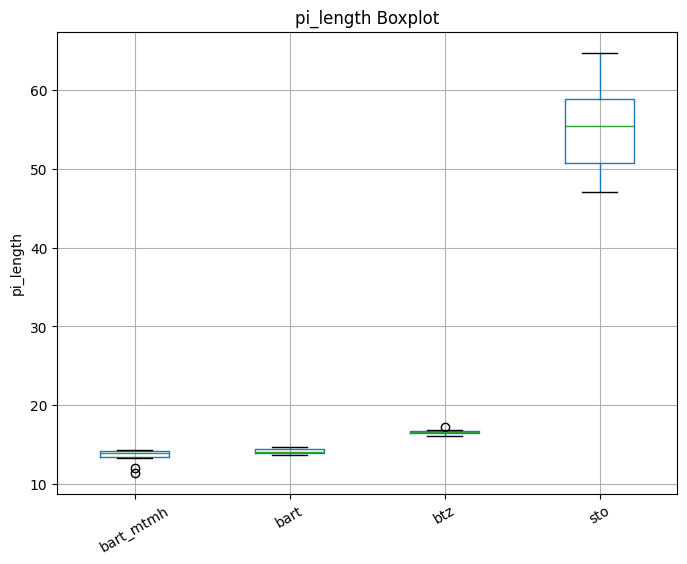

coverage:
      bart_mtmh      bart       btz       sto
0      0.922481  0.903101  0.945736  0.984496
1      0.937984  0.922481  0.906977  0.980620
2      0.941860  0.930233  0.953488  0.984496
3      0.937984  0.891473  0.941860  1.000000
4      0.949612  0.937984  0.953488  0.996124
5      0.914729  0.914729  0.937984  0.988372
6      0.941860  0.868217  0.934109  1.000000
7      0.965116  0.910853  0.953488  0.992248
8      0.852713  0.883721  0.926357  0.988372
9      0.903101  0.868217  0.930233  0.968992
mean   0.926744  0.903101  0.938372  0.988372
std    0.031459  0.024650  0.014782  0.009494



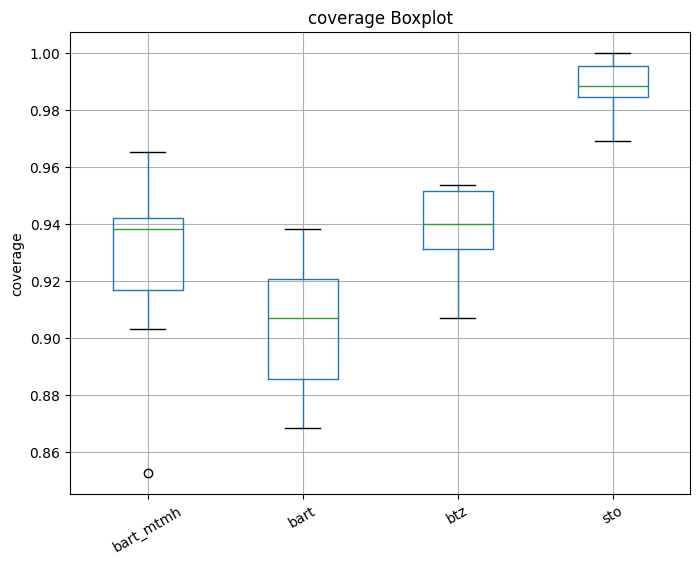

train_time:
      bart_mtmh       bart        btz        sto        rf       xgb
0     88.451203  11.721158  35.630902   9.495410  0.401509  0.198490
1     87.447528  11.628146  29.736024  10.646118  0.382024  0.132462
2     87.437002  11.563324  29.747128  10.834718  0.376306  0.129758
3     86.960559  11.605200  29.800062  10.829881  0.380141  0.203115
4     87.866852  11.527231  31.290171  10.312191  0.367699  0.142740
5     85.657503  11.345915  19.537194  14.910158  0.528605  0.069599
6     86.966533  12.493249  24.149681  11.739950  0.531545  0.078207
7     86.515486  11.966588  23.690928  11.673671  0.508748  0.074685
8     86.626333  12.631035  25.061497  11.777167  0.402223  0.062918
9     87.155723  32.379125  12.213297   7.754616  0.276838  0.035661
mean  87.108472  13.886097  26.085688  10.997388  0.415564  0.112763
std    0.769893   6.511457   6.704753   1.836225  0.082155  0.057759



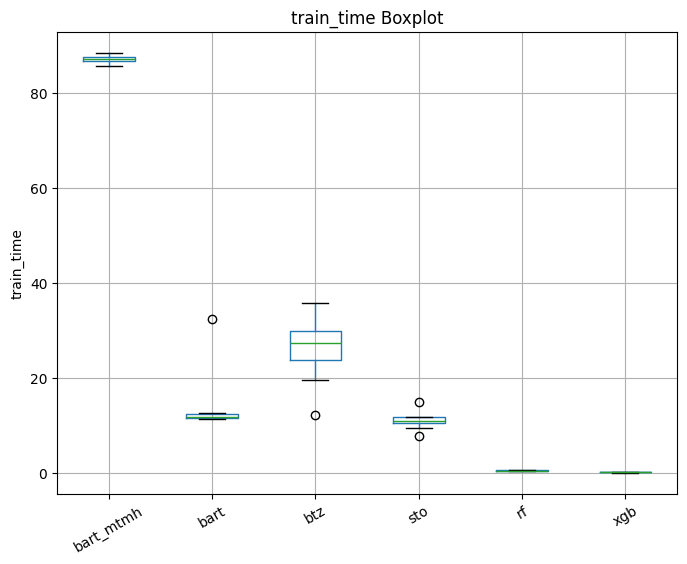

In [8]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [9]:
for k, v in mse_results.items():
    csv_name = f"results/real4_Concrete_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real4_Concrete_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real4_Concrete_tries.csv", index=False)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [8]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE   Test_MSE  Coverage  Train_Time
0            1     1.252344   1.381287  20.003305  0.910078   26.971360
1            5     1.197970   1.339547  19.612620  0.919380   57.556647
2           10     1.180081   1.288728  19.366922  0.916279   94.101910
3           50     1.078785   1.124731  16.040148  0.937984  383.216408
4          100     1.075322   1.120945  17.748036  0.942636  655.096327
